In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, distinct, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)

In [10]:
# Get a list of column names and types
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Get a list of column names and types
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#Viewing data in Station File
engine.execute("SELECT * FROM Station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [13]:
#Viewing data in Measurement file
engine.execute("SELECT * FROM Measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.prcp, Measurement.date).\
            filter(Measurement.date > '2016-08-23').\
            order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)

# Sort the dataframe by date
precip_df.sort_values(by="date")

#Rename columns
precip_df.rename(columns = {"date":"Date", "prcp":"Precipitation (in)"}, inplace=True)

#Set index to Date
precip_df.set_index("Date", inplace = True)
precip_df.head()

,Precipitation (in)
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


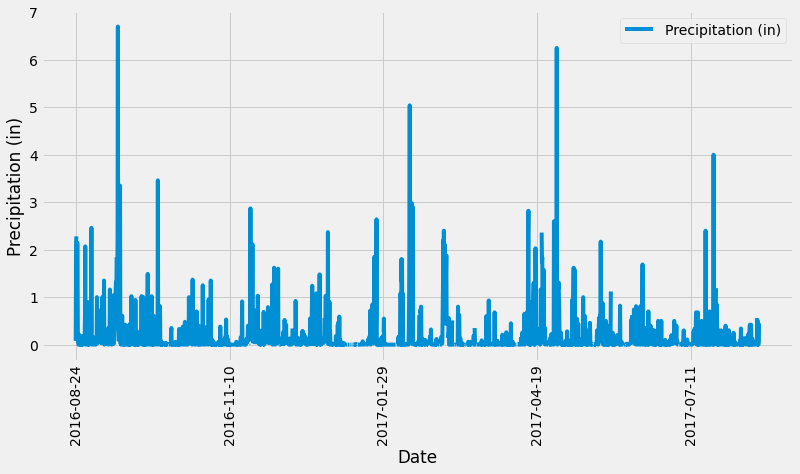

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(grid = True, rot = 90, figsize = (12, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Using the aggregation method
weather_stats = precip_df["Precipitation (in)"].agg(["mean", "median", "var", "std", "sem"])
weather_stats

mean      0.176462
median    0.020000
var       0.211865
std       0.460288
sem       0.010254
Name: Precipitation (in), dtype: float64

# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.station).count()
stations

9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
stationlist = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
  
# List the stations and the counts in descending order.
stationlist

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_pick = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281')

#print minimum temperature
minT = min(station_pick)
print(f'The minimum temperature was: {minT[0]}°F.')

#print maximum temperature
maxT = max(station_pick)
print(f'The maximum temperature was: {maxT[0]}°F.')

#Eliminating missing data
temp_list = []
for t in station_pick:
    if type(t.tobs) == float:
        temp_list.append(t.tobs)

#Importing mean function
from statistics import mean

#Computing mean and printing
meanT = round(mean(temp_list), 2)     
print(f'The mean temperature was: {meanT}°F.')


The minimum temperature was: 54.0°F.
The maximum temperature was: 85.0°F.
The mean temperature was: 71.66°F.


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data_12mo = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > '2016-08-23')

temp_list12 = []
for t in temp_data_12mo:
    if type(t.tobs) == float:
        temp_list12.append(t.tobs)

<function matplotlib.pyplot.show(*args, **kw)>

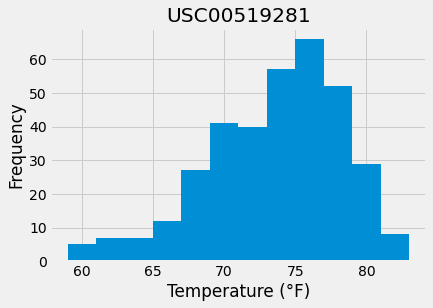

In [22]:
#Create np array
temp_array = np.array(temp_list12)

#Create histogram
plt.hist(temp_array, bins = 12)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title('USC00519281')
plt.show

# Close session

In [23]:
# Close Session
session.close()